In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Udayana/SNATIA/mobilejkn_processed (1).csv')
df = data[['preprocessed', 'label']].dropna()
df.head(10)

,preprocessed,label
0,"['webnya', 'bapuk', 'kurang', 'satset', 'gk', ...",negatif
1,['mantap'],positif
2,"['jauh', 'aplikasi', 'milik', 'perintah', 'mob...",positif
3,"['mau', 'ambil', 'no', 'antre', 'kontrolkuota'...",negatif
4,"['luarbiasa', 'mudah']",positif
5,"['mw', 'daftar', 'tp', 'otp', 'ga', 'kirim']",negatif
6,['mantap'],positif
7,"['aplikasi', 'sangat', 'mudah', 'laku', 'ubah'...",positif
8,"['sangat', 'bantu', 'sekali', 'aplikasi', 'sem...",positif
9,"['sangat', 'susah', 'sekali', 'verifikasi', 'w...",negatif


split data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])
print('Jumlah data latih:', len(X_train))
print('Jumlah data uji:', len(X_test))
print('Data berhasil di split.')

Jumlah data latih: 7878
Jumlah data uji: 1970
Data berhasil di split.


tf-idf

In [ ]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

smote

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_vec, y_train)
class_distribution = y_train_smote.value_counts()
print(class_distribution)

label
positif    5233
negatif    5233
Name: count, dtype: int64


logrec

In [ ]:
model_logrec = LogisticRegression(C=100, max_iter = 1000, class_weight='balanced', penalty='l2')
model_logrec.fit(X_train_smote, y_train_smote)

y_pred_logmodel = model_logrec.predict(X_test_vec)
param_grid_logrec = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search_logrec = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logrec, cv=5, scoring='accuracy')
grid_search_logrec.fit(X_train_smote, y_train_smote)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

multinomial nb

In [ ]:
model_nb = MultinomialNB(alpha = 0.1)
model_nb.fit(X_train_smote, y_train_smote)

y_pred_nb = model_nb.predict(X_test_vec)

param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, scoring='accuracy')
grid_search_nb.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]},
             scoring='accuracy')

In [ ]:
from sklearn.svm import SVC

model_svm = SVC(C=100, gamma=1)
model_svm.fit(X_train_smote, y_train_smote)

y_pred_svm = model_svm.predict(X_test_vec)

param_grid_svm = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']}
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, refit=True, verbose=3, cv=5)
grid_search_svm.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.924 total time=  12.7s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.921 total time=   7.9s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.923 total time=   5.9s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.905 total time=   6.8s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.899 total time=   5.7s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.920 total time=   4.5s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.916 total time=   4.4s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.928 total time=   4.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.935 total time=   4.2s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.931 total time=   4.5s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.884 total time=   7.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

evaluate

In [ ]:
best_log = grid_search_logrec.best_estimator_
y_pred_logmodel = best_log.predict(X_test_vec)
print("===== Kinerja Logistic Regression =====")
print("Parameter Logistic Regression: ", grid_search_logrec.best_params_)
print("Akurasi:", accuracy_score(y_test, y_pred_logmodel))
print("Classification Report: \n", classification_report(y_test, y_pred_logmodel))

best_nb = grid_search_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test_vec)
print("===== Kinerja Naive Bayes =====")
print("Parameter Naive Bayes: ", grid_search_nb.best_params_)
print("Akurasi:", accuracy_score(y_test, y_pred_nb))
print("Classification Report: \n", classification_report(y_test, y_pred_nb))

best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_vec)
print("===== Kinerja SVM =====")
print("Parameter SVM: ", grid_search_svm.best_params_)
print("Akurasi:", accuracy_score(y_test, y_pred_svm))
print("Classification Report: \n", classification_report(y_test, y_pred_svm))

===== Kinerja Logistic Regression =====
Parameter Logistic Regression:  {'C': 100, 'penalty': 'l2'}
Akurasi: 0.9248730964467005
Classification Report: 
               precision    recall  f1-score   support

     negatif       0.88      0.89      0.89       662
     positif       0.95      0.94      0.94      1308

    accuracy                           0.92      1970
   macro avg       0.92      0.92      0.92      1970
weighted avg       0.93      0.92      0.92      1970

===== Kinerja Naive Bayes =====
Parameter Naive Bayes:  {'alpha': 0.1}
Akurasi: 0.8578680203045685
Classification Report: 
               precision    recall  f1-score   support

     negatif       0.71      0.97      0.82       662
     positif       0.98      0.80      0.88      1308

    accuracy                           0.86      1970
   macro avg       0.85      0.89      0.85      1970
weighted avg       0.89      0.86      0.86      1970

===== Kinerja SVM =====
Parameter SVM:  {'C': 100, 'gamma': 0.1, 'ker

cm

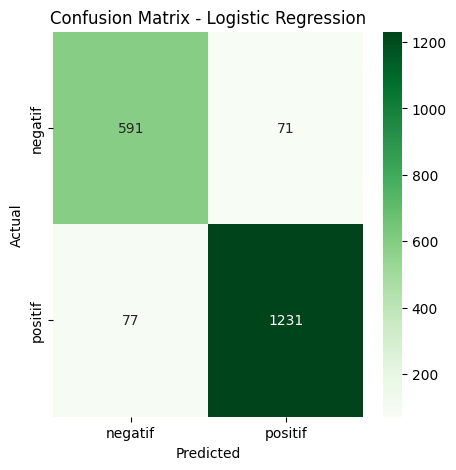

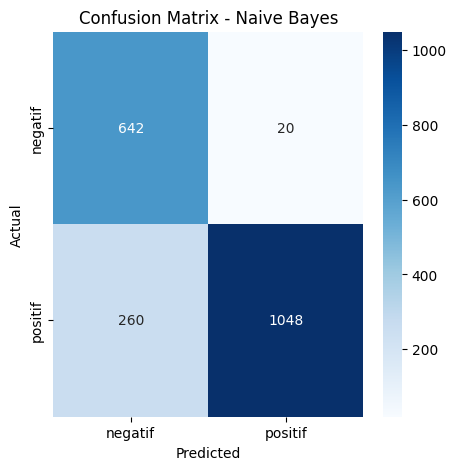

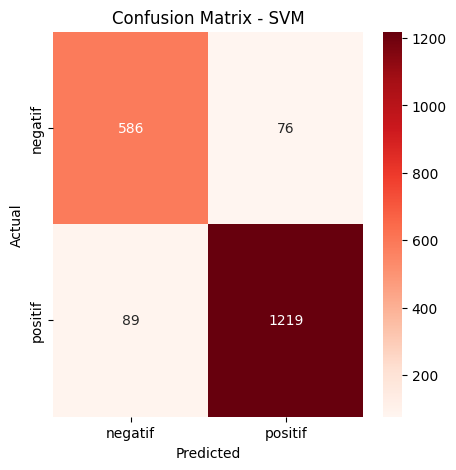

In [ ]:
labels = sorted(y_test.unique())
cm_logrec = confusion_matrix(y_test, y_pred_logmodel, labels=labels)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_logrec, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

cm_nb = confusion_matrix(y_test, y_pred_nb, labels=labels)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=labels)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

pie chart

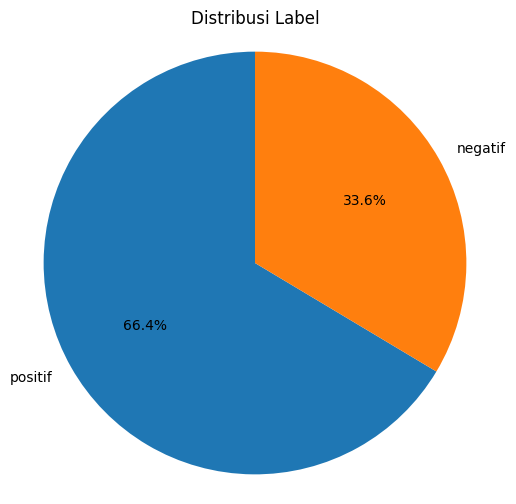

In [ ]:
count_label = df['label'].value_counts()
plt.figure(figsize=(6, 6))
colors = ['#ff9999', '#66b3ff', '#99ff99']
plt.pie(count_label, labels=count_label.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Label')
plt.axis('equal')
plt.show()